# CSC3831 Final Assessment - Part I: Data Engineering



In [76]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from IPython.lib.editorhooks import scite
from jupyter_server.extension.utils import validate_extension
from pandas.core.common import random_state

# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('houses_0_01_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)  
print(houses_corrupted.head())




   median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1          1106.0      2401.0      1138.0     37.86    -122.22  
2           190.0         NaN       177.0     37.85    -122.24  
3           235.0         NaN       219.0     37.85    -122.25  
4           280.0       565.0       259.0     37.85    -122.25  


Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


### Note:
pandas is built on top of scipy and numpy, so I may reference/ link these libraries rather than pandas directly \
\
I will also assume this dataset is a __sample__ and not a population. (not that it makes a significant difference for a dataset this size) 


Let's start by getting some basic information about the dataset

In [77]:
print(houses_corrupted.info()) # info about the dataset
"""
let's find out some information about each feature in the dataset
"""

for i in houses_corrupted.columns:
    print("\n")
    print(houses_corrupted[i].describe()) #note this excludes NaN values - so any missing values will not be included in the count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64


count    18576.000000
mean         3.929958
std          1.964296
min          

Lets find some correlations between the features...

          Feature1       Feature2  Correlation
median_house_value  median_income     0.694887
       total_rooms total_bedrooms     0.929893
       total_rooms     population     0.857515
       total_rooms     households     0.918484
    total_bedrooms     population     0.877178
    total_bedrooms     households     0.979829
        population     households     0.907096
          latitude      longitude    -0.924664


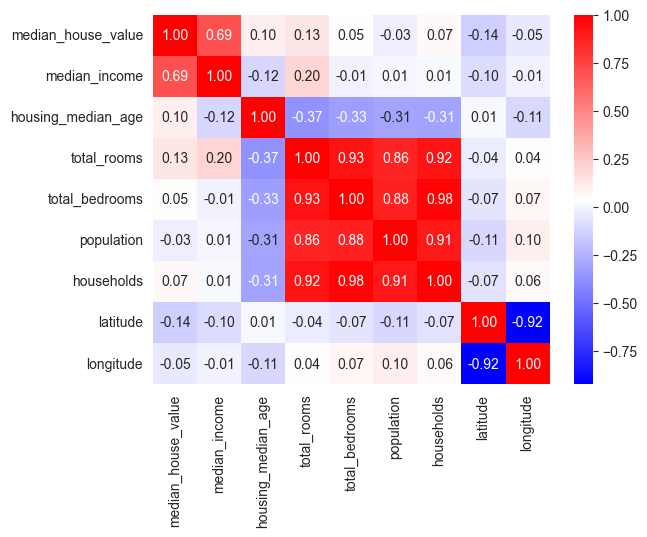

In [78]:

correlation_mat = houses_corrupted.corr(method = "pearson") # see how every feature correlates with each other using pearson correlation

plt.figure(1)
sns.heatmap(correlation_mat, annot=True, cmap="bwr", fmt=".2f")

# a programmatic approach to identifying highly correlated features

threshold = 0.65 #may seem a bit high - might change
corr_pairs = correlation_mat.unstack()
corr_pairs = corr_pairs[abs(corr_pairs) > threshold] # get all pairs with correlation above threshold
corr_pairs = corr_pairs[corr_pairs < 1] # remove self correlation
corr_pairs = pd.DataFrame(corr_pairs).reset_index() 
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation'] # rename columns
corr_pairs = corr_pairs.drop_duplicates(subset='Correlation') # drop duplicates
print(corr_pairs.to_string(index=False)) # print out the highly correlated featurez


Let's check skewness - a measure of how much the distribution of a feature deviates from a normal distribution. the formula for skewness is: 
$$
  skew = \frac{n}{(n-1)(n-2)} \sum_{i=1}^{n} \left( \frac{x_i - \bar{x}}{s} \right)^3
$$
[1] source - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html

In [79]:

for i in houses_corrupted.columns:
    #plt.figure() #this is needed to display all figures (on pycharm anyway)
    #sns.kdeplot(houses_corrupted[i]) #plot the density of each feature, uncomment if you want to see it
    print(f"Skewness of {i} is {houses_corrupted[i].skew():.3f}") #print the skewness of each feature using the pearson-first-moment-coefficient method


Skewness of median_house_value is 0.978
Skewness of median_income is 1.588
Skewness of housing_median_age is 0.085
Skewness of total_rooms is 4.147
Skewness of total_bedrooms is 3.453
Skewness of population is 4.826
Skewness of households is 3.410
Skewness of latitude is 0.466
Skewness of longitude is -0.298


It can be said here that the dataset is skewed in some features 
* population , households, total_bedrooms, total_rooms, median_income are all right skewed
* total_bedrooms, total_rooms, median_income I expect to be right skewed as a tiny population of people will have a large number of bedrooms, rooms and income
* median_house_value is left skewed but there is a tiny bump which could be anamolous data
* longitude and latitude are bimodal oppoosites.
* housing_median_age is almost perfectly symmetrical (normal)

- skewness of 0.5 to -0.5 is considered symmetrical
- skewness of |0.5| to |1| is considered moderately skewed
- skewness of |1| or more is considered highly skewed

when your data is skewed using mean and standard deviation can be misleading as they overrepresent outliers. Instead we can:
- M.A.D in place of standard deviation
- The median instead of the mean

To transform our features to become less skewed we can do a log transformation. We will take log base 10 in this case. I see no point in log transforming the longitiude and latitude as:
- they are not (really) skewed
- they have negative values 

[2] https://onlinestatbook.com/2/transformations/log.html

In [80]:
houses_corrupted_log = houses_corrupted.copy()  #drop the longitude and latitude columns
my_columns = ["median_house_value", "median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households"] #without longitude and latitude
houses_corrupted_log[my_columns] = np.log10(houses_corrupted_log[my_columns]) #log transform the dataset

for feature in my_columns:
    #plt.figure() #this is needed to display all figures (on pycharm anyway)
    #sns.kdeplot(houses_corrupted_log[feature]) #plot the density of each feature, uncomment if you want to see it
    print(f"Skewness of {feature} is {houses_corrupted_log[feature].skew():.3f}") #print the skewness of each feature using the pearson-first-moment-coefficient

Skewness of median_house_value is -0.173
Skewness of median_income is -0.147
Skewness of housing_median_age is -1.269
Skewness of total_rooms is -1.097
Skewness of total_bedrooms is -1.061
Skewness of population is -1.204
Skewness of households is -1.124


As you can see the skewness of the features has been reduced. The features are now more symmetrical and closer to a normal distribution. Although we can continue our ad hoc EDA with this transformed dataset, I won't be doing that and will just use the original dataset for the rest of the analysis.  However I may use it for anaomlie detection and imputation later on.

[2] https://onlinestatbook.com/2/transformations/log.html 

Now let's check for  Kurtosis - a measure of the "tailedness" of the distribution. The formula for kurtosis is:
$$
kurtosis = \frac{n(n+1)}{(n-1)(n-2)(n-3)} \sum_{i=1}^{n} \left( \frac{x_i - \bar{x}}{s} \right)^4 - \frac{3(n-1)^2}{(n-2)(n-3)}
$$
[1] source - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html


In [81]:

for i in houses_corrupted.columns:
    #print the kurtosis of each skips NaN values, uses the fisher method by default
    print(f"Kurtosis of {i} is {houses_corrupted[i].kurtosis():.3f}")


Kurtosis of median_house_value is 0.328
Kurtosis of median_income is 4.501
Kurtosis of housing_median_age is -0.794
Kurtosis of total_rooms is 32.631
Kurtosis of total_bedrooms is 21.923
Kurtosis of population is 70.438
Kurtosis of households is 22.058
Kurtosis of latitude is -1.118
Kurtosis of longitude is -1.330


Kurtosis is a measure of how much the tails of a distribution differ from the tails of a normal distribution. sharper ones are called leptokurtic and flatter ones are called platykurtic. Generally, a normal distribution has a kurtosis of 0. leptokurtic distributions have a kurtosis greater than 0 and are caused by extreme outliers in the dataset causing it to peak. platykurtic distributions have a kurtosis more than 0 and are generally caused by a smoother data distribution with more consistent data points. in this case, we have a few features that are leptokurtic and platykurtic:
* population, households, total_bedrooms, total_rooms, median_income are all leptokurtic
* median_house_value and housing_median_age are the closest we have to a normal distribution (kurtosis of 0)
* longitude and latitude are platykurtic

[2] [source] (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html), [3] (https://www.investopedia.com/terms/k/kurtosis.asp)

let's find missing information via brute force:

In [82]:
"""
Brute force method to find missing information from the dataset
"""
nan_records = {} #dict to store
median_age_rows = [] #used later for imputations
for index, row in houses_corrupted.iterrows():
    nan_columns = row[row.isna()].index.tolist() #get all columns in each row that has a NaN value
    if nan_columns:
        nan_records[index] = nan_columns #append to dict

for key,value in nan_records.items():
    # only print if you want to see it
    print(f"Row {key} has NaN values in columns {value}")
    if "housing_median_age" in value:
        median_age_rows.append(key) #used later
print("number of missing records: ", len(nan_records))


Row 2 has NaN values in columns ['population']
Row 3 has NaN values in columns ['population']
Row 10 has NaN values in columns ['housing_median_age']
Row 14 has NaN values in columns ['median_income']
Row 16 has NaN values in columns ['median_income']
Row 17 has NaN values in columns ['median_income', 'population']
Row 18 has NaN values in columns ['median_income', 'housing_median_age']
Row 19 has NaN values in columns ['median_income']
Row 20 has NaN values in columns ['median_income']
Row 21 has NaN values in columns ['median_income', 'housing_median_age']
Row 22 has NaN values in columns ['housing_median_age']
Row 24 has NaN values in columns ['housing_median_age']
Row 32 has NaN values in columns ['housing_median_age']
Row 35 has NaN values in columns ['population']
Row 36 has NaN values in columns ['housing_median_age']
Row 37 has NaN values in columns ['housing_median_age']
Row 38 has NaN values in columns ['population']
Row 40 has NaN values in columns ['median_income', 'housing

we use a brute force approach - we iterate through all the records (rows) and check every item within the row that isn't a number (NaN).

we record the index of the row and the columns that have NaN values in a dictionary which we will later impute


What's interesting about this is that there doesn't seem to be any missing data in the "longitude" or "latittude" columns - we can actually plot this coordinates and find out where the data is taken from


In [83]:
"""
Plot the coordinates of the houses using folium
No need to run this code - good visualisation but not necessary
"""

import folium
from IPython.display import IFrame

#start at mean of the coordinates
m = folium.Map(location=[houses_corrupted["latitude"].mean(), houses_corrupted["longitude"].mean()], zoom_start=6) 
for index, row in houses_corrupted.iterrows():
    #plot the coordinates of each record
    folium.Circle(location=[row["latitude"], row["longitude"]], radius=100, color='blue', fill=True, fill_color='blue').add_to(m)
    
m.save("housing_map.html") #open the html file (in a browser)

"""
to see the map - You can plot native folium maps in jupyter notebook but google colab does not support HTML embeds
uncomment this if you're not running something that supports HTML embeds (Pycharm, Jupyter Notebook):
"""

#IFrame(src='housing_map.html', width=700, height=600) #display the map in the notebook

"\nto see the map - You can plot native folium maps in jupyter notebook but google colab does not support HTML embeds\nuncomment this if you're not running something that supports HTML embeds (Pycharm, Jupyter Notebook):\n"

Looks like Cali!

__lets compare features__


First we can see what features have the most extreme range relative to the M.A.D. So we can compare them easier
$$  
\text{M.A.D} = \text{median} (|x_i - \widetilde{X}|)
$$

$$
\text{Relative Range} = \frac{X_{max} - X_{min}}{\text{M.A.D}}
$$


In [84]:
from scipy.stats import median_abs_deviation
relative_range_dict = {}
for feature in houses_corrupted.columns:
    M_A_D = median_abs_deviation(houses_corrupted[feature], nan_policy="omit")#median absolute deviation
    my_range = (houses_corrupted[feature].max() - houses_corrupted[feature].min()) / M_A_D
    relative_range_dict[feature] = my_range
 
for key,val  in relative_range_dict.items():
    print(f"Relative Range of {key} is {val:.3f}")


Relative Range of median_house_value is 7.091
Relative Range of median_income is 12.950
Relative Range of housing_median_age is 5.667
Relative Range of total_rooms is 49.332
Relative Range of total_bedrooms is 39.534
Relative Range of population is 78.936
Relative Range of households is 40.272
Relative Range of latitude is 7.650
Relative Range of longitude is 7.844


Looking at this we can see that the features with the most extreme ranges are:
- total_rooms
- total_bedrooms
- population
- households

### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


For statsical method we can use the **IQR * 1.5** method to identify outliers:
$$
IQR = Q_3 - Q_1\\
$$
$$
Q_L = Q_1 - 1.5 \times IQR\\
$$
$$
Q_U = Q_3 + 1.5 \times IQR\\
$$
$$
\text{Data point } x \text{ is considered anomalous if } x \notin [Q_L, Q_U]\\
$$

The reason I chose this method it's simple to understand - I will using the log dataset here because it works best with symmetrical data

[5] [source] (https://wis.kuleuven.be/stat/robust/papers/2008/outlierdetectionskeweddata-revision.pdf)



In [85]:
"""
Statistical Outlier Detection using IQR * 1.5
"""

def IQR_outliers(df):
    outliers = {}
    bounds = {}
    
    for column in df.columns:
    # Calculate Q1, Q3, and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
    
    #calculate the upper and lower bounds
        Q_L = Q1 - 1.5 * IQR
        Q_U = Q3 + 1.5 * IQR

    # Identify and store outliers
        outliers[column] = df.loc[(df[column] < Q_L) | (df[column] > Q_U)] 
        bounds[column] = (Q_L, Q_U)

    # Print the number of outliers in each column / feature 
        print(f"Outliers in {column}: {len(outliers[column])} between {Q_L:.3f} and {Q_U:.3f} with median of {houses_corrupted[column].median():.3f}")

    print("total number of outliers: ", sum([len(outliers[column]) for column in df.columns]))

    return outliers, bounds


Now we can plot the boxplots of the features to see where the outliers are

Outliers in median_house_value: 26 between 4.560 and 5.940 with median of 179700.000
Outliers in median_income: 215 between -0.011 and 1.106 with median of 3.572
Outliers in housing_median_age: 677 between 0.786 and 2.038 with median of 28.000
Outliers in total_rooms: 956 between 2.655 and 4.004 with median of 2127.000
Outliers in total_bedrooms: 816 between 1.958 and 3.323 with median of 435.000
Outliers in population: 915 between 2.425 and 3.754 with median of 1227.000
Outliers in households: 885 between 1.945 and 3.284 with median of 409.000
Outliers in latitude: 0 between 28.260 and 43.380 with median of 34.260
Outliers in longitude: 0 between -127.485 and -112.325 with median of -118.490
total number of outliers:  4490


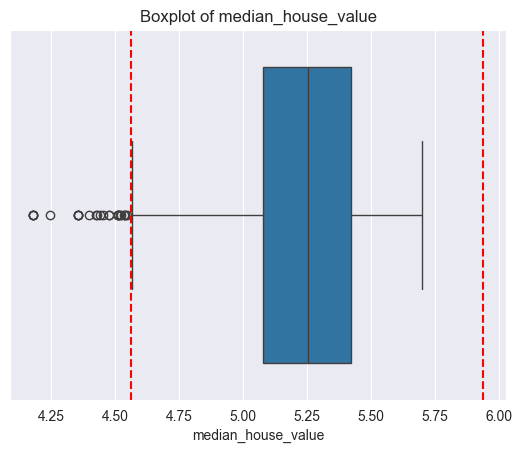

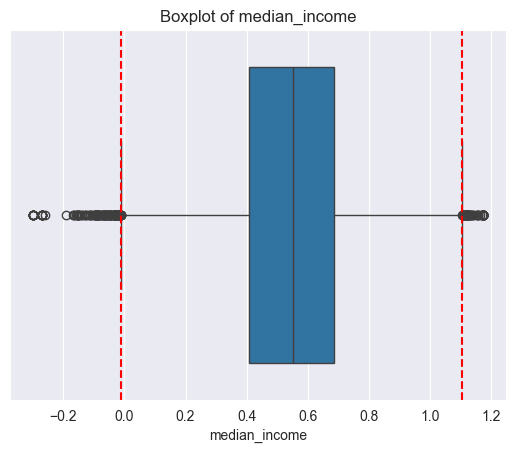

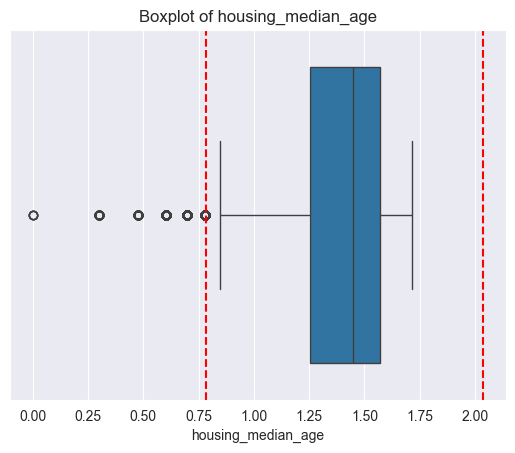

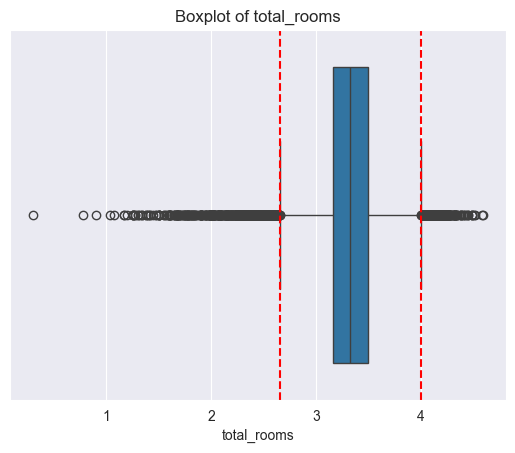

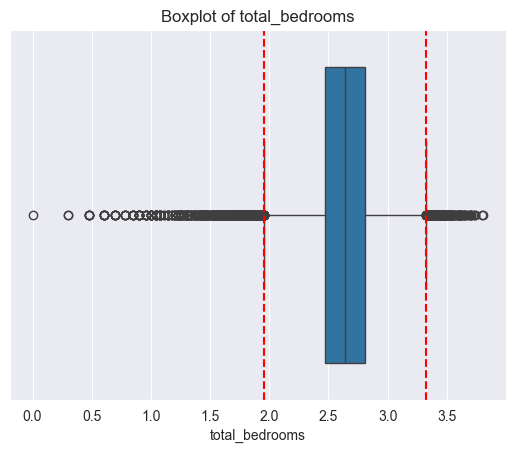

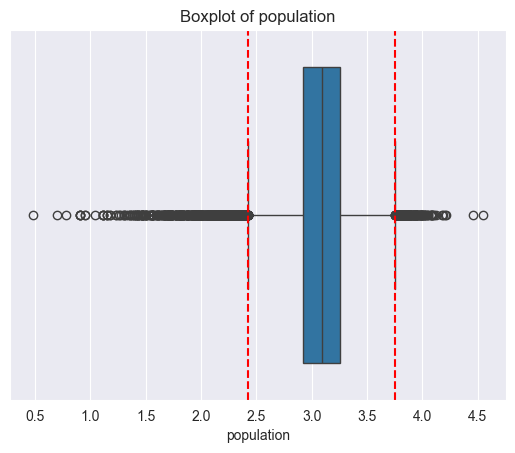

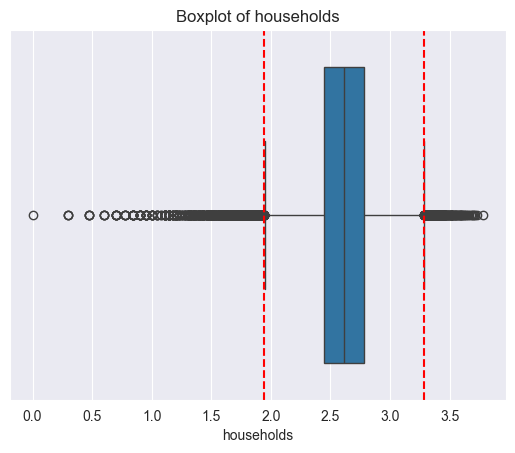

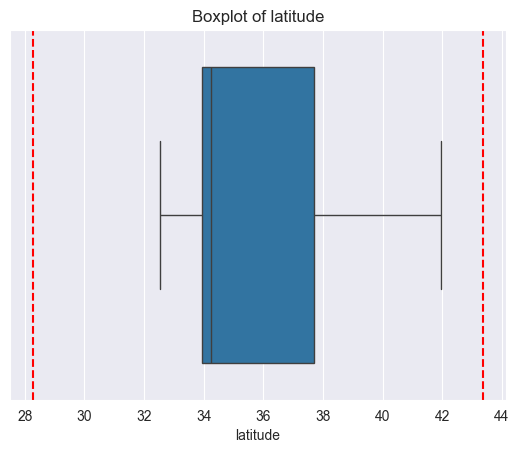

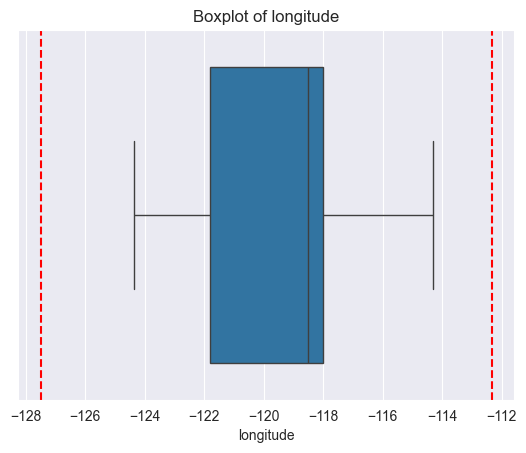

In [86]:
log_outliers , log_bounds = IQR_outliers(df = houses_corrupted_log)
for feature in houses_corrupted_log.columns:
    plt.figure()
    sns.boxplot(x=houses_corrupted_log[feature])
    plt.axvline(log_bounds[feature][0], color='r', linestyle='--')
    plt.axvline(log_bounds[feature][1], color='r', linestyle='--')
    plt.title(f"Boxplot of {feature}")
    #plt.show()

In this case the feature with the most amount of outliers is **total_rooms** with 956 outliers. The feature with the least amount of outliers is, **latitude** and **longitutde** with 0 outliers. But this is expected as they are not skewed and are bimodal.

We can visualise this with a box plot.
In the box plots the red-dashed lines represent the upper and lower bounds of the IQR. We can see that for the skewed data, there were A LOT of outliers in fact for the features:
- total_rooms
- total_bedrooms
- population
- households

approximately 6% of the data is considered an outlier (about 1200 outliers out of 20,640 records (includes NaN values)). If we were to conduct the same method on the log transformed dataset, we would see fewer outliers as the data is more symmetrical and closer to a normal distribution. Feel free to run the code below, I have commented it out since I don't wish for it to be the main focus as I am sticking with the original dataset.

there are multiple features that no outliers at all:
- housing_median_age
- latitude
- longitude

Now the IQR method only detects point anomalies (i.e points that are on the far end of the distribution). So it may not capture other anomalies such as contextual anomalies. I'll talk more about this when comparing it with the algorithmic method.

In [87]:
"""
uncomment and run this code if you want to compare outliers on the raw dataset.
"""
# outliers_iqr , bounds_iqr = IQR_outliers(df = houses_corrupted)
# for feature in houses_corrupted.columns:
#     plt.figure()
#     sns.boxplot(x=houses_corrupted[feature])
#     plt.axvline(bounds_iqr[feature][0], color='r', linestyle='--')
#     plt.axvline(bounds_iqr[feature][1], color='r', linestyle='--')
#     plt.title(f"Boxplot of {feature}")

'\nuncomment and run this code if you want to compare outliers on the raw dataset.\n'

For the algorithmic approach we can use the **Isolation Forest** algorithm.

Isolation Forest is a tree based algorithm it works by:
- Pick a random feature
- Pick a random value for that feature
- Split the data based on that value
- Repeat until the data is split into individual points
- The number of splits it takes to isolate a point is the anomaly score
- The lower the score the more anomalous the point is
- repeat with multiple trees and average the path lengths to get the anomaly score

Matheamatically the anomaly score is:
$$
s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$$
where:
- $h(x)$ is the path length of point x
- $E(h(x))$ is the average (expected) path length of point x
- $c(n)$ is a normalization constant that depends on the number of points in the dataset

$$
c(n) = 2H(n-1) - \frac{2(n-1)}{n}
$$
where:
- $H(i)$ is the harmonic number and is approximately $ln(i) + 0.5772156649 \text{(eulers constant)}$


the lower the value of $s(x,n)$ the more anomalous the point is (shorter path length until isolation)


[4] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html [5] https://www.lamda.nju.edu.cn/publication/icdm08b.pdf

Number of outliers detected: 2337
Explained Variance Ratio: [0.90352365 0.04287094]


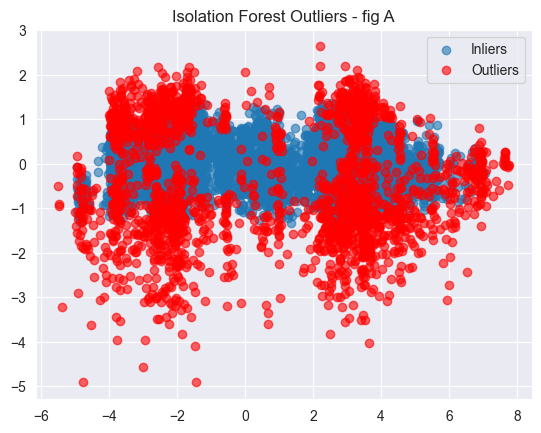

Mean score for inliers: -0.4237
Mean score for outliers: -0.5533


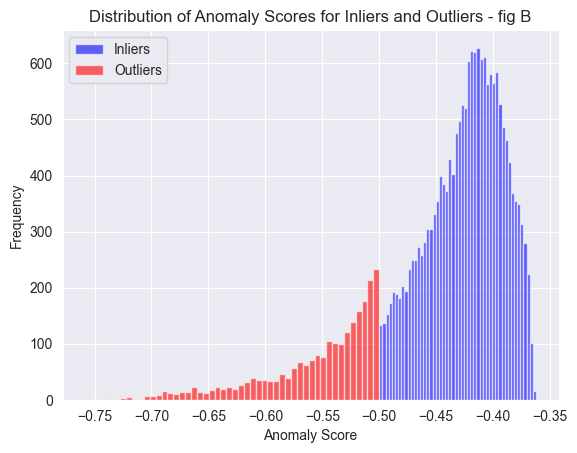

In [88]:
from sklearn.ensemble import IsolationForest
"""
Algorithmic Outlier Detection using Isolation Forest
We have to create a copy of our dataset and remove the NaN values as the Isolation Forest algorithm does not work with NaN values.
Again we will be using the log transformed data
I will be using PCA to reduce the dimensions to 2 so we can visualise the outliers
"""

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

houses_corrupted_log_copy = houses_corrupted_log.copy()
houses_corrupted_log_copy.fillna(houses_corrupted_log.median(), inplace=True) #fill NaN values with the median

iso_dict = {}

#As this coursework is more focused on the analsysis and comparison of anamaoly detection I will not be tuning the hyperparameters a lot
iso_forest = IsolationForest(
    contamination='auto', #set this to auto as we don't know the exact number of outliers
    random_state=69, #set the random state so the results are reproducible
    n_estimators= 200, #number of trees in the forest, default is 100, I'll put it as 200 as our dataset is large
    max_samples= 256, #number of samples to draw from the dataset to train each tree, default is 256
    max_features= 9) #use all features
#I chose the random state of 50 so that the results are reproducible

# Fitting the Isolation Forest model to the data
iso_forest.fit(houses_corrupted_log_copy)

# Predicting outliers
outliers_iso = iso_forest.predict(houses_corrupted_log_copy)

for indx, val in enumerate(outliers_iso):
    if val == -1:
        iso_dict[indx] = val

print(f"Number of outliers detected: {len(iso_dict)}")

#trying to visualise the outliers using PCA to reduce the dimensions to 2
#works by finding the directions of maximum variance in the data
#the first principal component is the direction of maximum variance, the second is the direction of the next maximum variance, and so on.
#all components are orthogonal to each other
pca = PCA(n_components=2)
pca_result = pca.fit_transform(houses_corrupted_log_copy)
var_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {var_ratio}")
plt.figure()
plt.scatter(pca_result[outliers_iso == 1, 0], pca_result[outliers_iso == 1, 1], label='Inliers', alpha=0.6)
plt.scatter(pca_result[outliers_iso == -1, 0], pca_result[outliers_iso == -1, 1], color='red', label='Outliers', alpha=0.6)
plt.title("Isolation Forest Outliers - fig A")
plt.legend()
plt.show()

#plot the anomaly scores - please read - https://stackoverflow.com/questions/68061530/what-is-the-difference-between-decision-function-and-score-samples-in-isolation
anomaly_scores = iso_forest.score_samples(houses_corrupted_log_copy)
# Extracting the inliers and outliers based on the decision function
inlier_scores = anomaly_scores[outliers_iso == 1]
outlier_scores = anomaly_scores[outliers_iso == -1]

print(f"Mean score for inliers: {inlier_scores.mean():.4f}")
print(f"Mean score for outliers: {outlier_scores.mean():.4f}")

plt.hist(inlier_scores, bins=50, color='blue', alpha=0.6, label="Inliers")
plt.hist(outlier_scores, bins=50, color='red', alpha=0.6, label="Outliers")
plt.title("Distribution of Anomaly Scores for Inliers and Outliers - fig B")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()



In the figures above we can see how many anamolies were detected by the isolation forest algorithm.


**Fig A** shows the outliers in the dataset through PCA. The explained variance ratio for these two PCA are 0.9 and 0.04 which sum to 0.94. This means that 94% of the datas variance is captured within these two principal components and a nice visualsiation can be made. We can see that on the x-axis the data is more spread out, as it holds more variance. As far as anamoly detection goes: We can see that all the inliers are concentrated at one point of principal component 2 (about y=0) as it has a low variance. The outliers that are spread across the y-axis are bound to be more anomalous. For the x-axis as it has a higher variance the outliers and inliners are more mixed.


**Fig B** shows the distribution of the anomaly scores for the inliers and outliers. The inliers have a mean score of -0.42 and the outliers have a mean score of -0.55. The lower the score the more anomalous the point is. We can see that the inliers are within a score of about (-0.50, -0.375) and the majority of the outliers are about (-0.51, -0.72). So within a smaller range we have a larger concentration (higher frequency) of inliers and within a larger range we have fewer outliers. Which is expected as the outliers will have a more varied anamoly score with a lot less frequency.


Now comparing the two results will be weird as the IQR method is applied independently to each feature and the isolation forest is applied to the entire dataset. What we can do is use the longitutde and latitude to plot the outliers of both methods and see where their concentration is.

number of ISolation Forest outliers: 2337


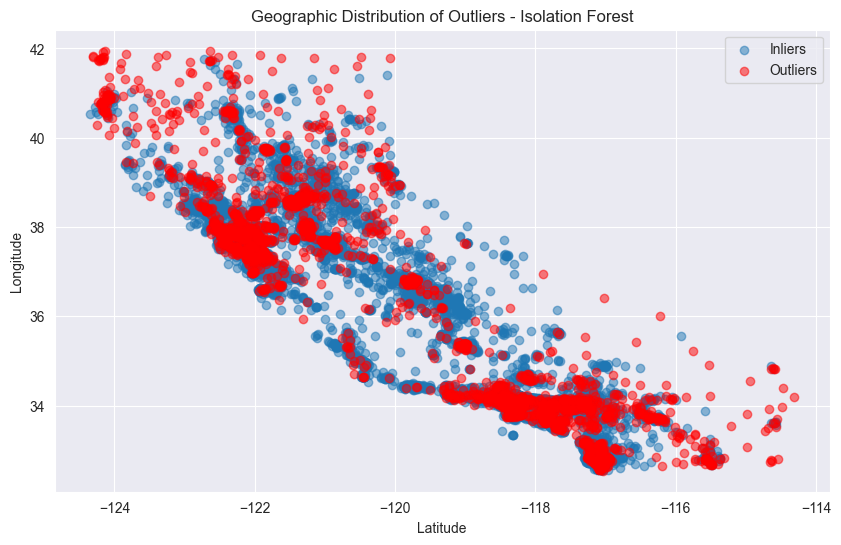

number of IQR outliers: 1958


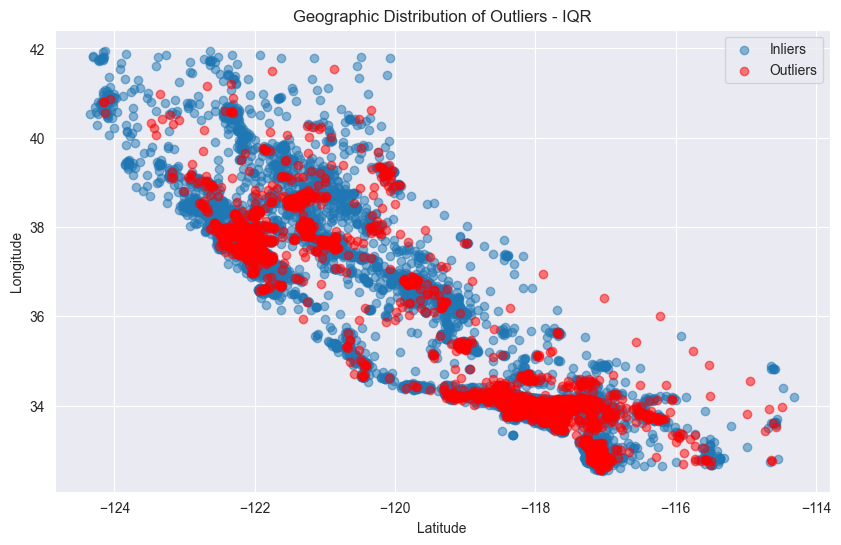

the number of rows methods overlap on: 1508


In [89]:
"""
plotting the outliers and inliners of the IQR and Isolation Forest methods against the longitude and latitude.
"""

# Extracting the longitude and latitude into a separate dataframe, we didnt log transform the longitude and latitude so it's fine to use the original dataset
longitude = houses_corrupted['longitude']
latitude = houses_corrupted['latitude']


#plotting mapped to the coordinates for Isolation Forest
print(f"number of ISolation Forest outliers: {len(iso_dict)}")
plt.figure(figsize=(10, 6)) #make the figure bigger

plt.scatter(longitude[outliers_iso == 1],
            latitude[outliers_iso == 1],
            label='Inliers',
            alpha=0.5) #plot the inliers

plt.scatter(longitude[outliers_iso == -1],
            latitude[outliers_iso == -1],
            color='red',
            label='Outliers',
            alpha=0.5)#plot the outliers
plt.title("Geographic Distribution of Outliers - Isolation Forest")

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.show()

#store all rows in a set - prevents duplicate rows
outlier_set = set()
count = 0
for feature, outlier in log_outliers.items():
    outlier_set.update(outlier.index)

print(f"number of IQR outliers: {len(outlier_set)}")
plt.figure(figsize=(10, 6)) #make the figure bigger
plt.scatter(longitude.drop(list(outlier_set)),
            latitude.drop(list(outlier_set)),
            label='Inliers',
            alpha=0.5) #plot the inliers

plt.scatter(longitude[list(outlier_set)],
            latitude[list(outlier_set)],
            color='red',
            label='Outliers',
            alpha=0.5) #plot the outliers

plt.title("Geographic Distribution of Outliers - IQR")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.show()

#amount of records that overlap
print(f"the number of rows methods overlap on: {len(outlier_set.intersection(iso_dict.keys()))}")

Straight away, we can see that the distrubution of outliers (along their latitude and longitude) are very similar across the two methods. We can see that the number of rows they overlap on is **1509**, meaning about **66%** of Isolation forest outliers and **76%** of IQR outliers are the same. Since both methods detected these anomalies, there is a high chance that they are **true** anamolies.

Now the first thing you may notice is that the amount of IQR anomalies has changed from **4498** (when we initially conducted the IQR method) to **1984** this is because the IQR method may pick up multiple anamolous features in the same row. So when they are mapped against the coordinates, they are counted as one anamoly. Simple math dictates that each anomalous row had about 2.26 anomalous features. This further clarifies why there is much more overlap between the two methods as it makes it easier for Isoaltion Forest to pick up on these anomalies.

IsolationForest detected more outliers because it can detect contextual anomalies, anomalies that are anomalous in the context of the entire dataset. For example, a cluster of neighborhoods (or coordinates in this case) may have a single house that is significantly more expensive than the rest in its area but not more expensive than the houses in the rich part of town. These anomalies will be picked up by isolation forest because it doesn't fit it in to its area (context), but won't be picked up by the IQR method. An example of this can be seen at the cluster seen at about **(-114.5, 35)**.

To further visualise this we can actually plot the scores of the anamolies

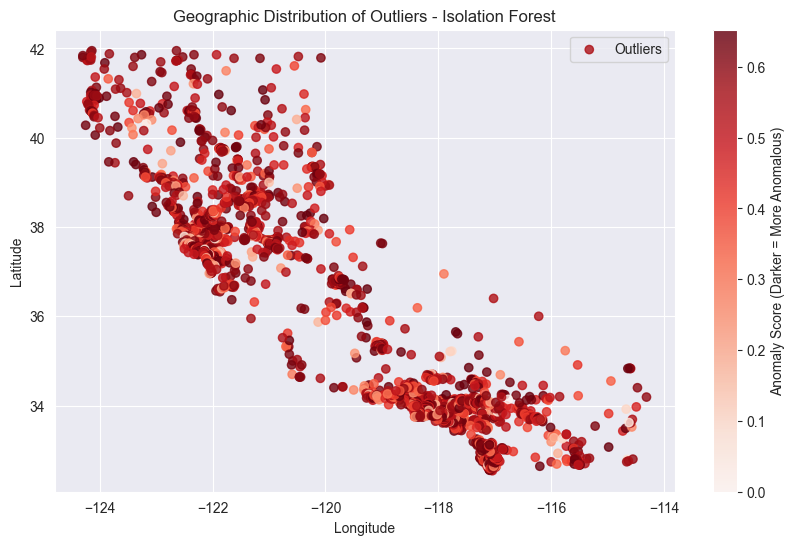

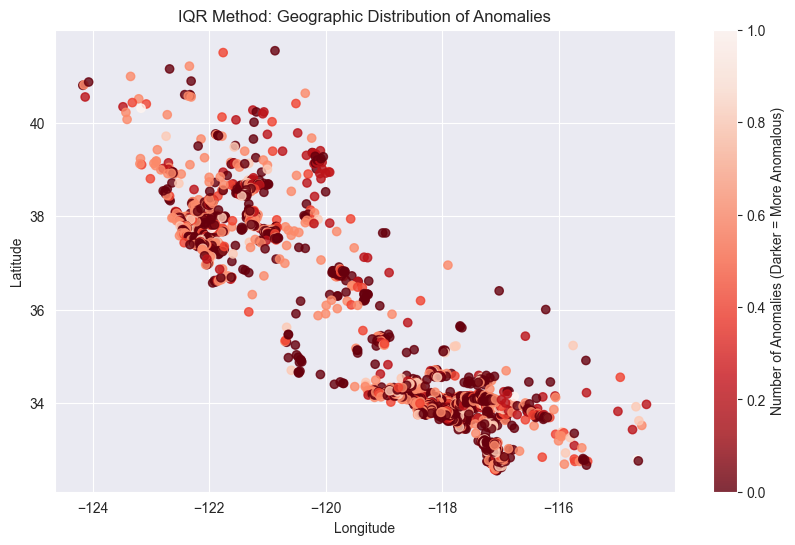

In [90]:
"""
plotting the anomaly scores of the Isolation Forest and IQR method against the longitude and latitude.
Normalising the scores so they are easily visualised and compared
"""



norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min()) #normalise the scores

plt.figure(figsize=(10, 6))
plt.scatter(
    longitude[outliers_iso == -1],
    latitude[outliers_iso == -1],
    c=norm_scores[outliers_iso == -1],  # Use normalized scores for coloring
    cmap='Reds',  # Colormap for outliers
    label='Outliers',
    alpha=0.8
)


plt.colorbar(label="Anomaly Score (Darker = More Anomalous)")
plt.title("Geographic Distribution of Outliers - Isolation Forest")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

#ceate a series for all the rows that are outliers
anomaly_counts = pd.Series(0, index=houses_corrupted.index)

# Count the number of anomalies for each row
for column, outliers in log_outliers.items():
    anomaly_counts[outliers.index] += 1

# Filter rows with anomalies and fetch their coordinates
anomalies = anomaly_counts[anomaly_counts > 0]
longitude_anomalies = longitude[anomalies.index]
latitude_anomalies = latitude[anomalies.index]
anomaly_counts_anomalies = anomalies #store the anomalie counts

norm_counts_anomalies = (anomaly_counts_anomalies - anomaly_counts_anomalies.min()) / (anomaly_counts_anomalies.max() - anomaly_counts_anomalies.min())

# Plotting anomalies
plt.figure(figsize=(10, 6))
plt.scatter(
    longitude_anomalies,
    latitude_anomalies,
    c=norm_counts_anomalies ,  # Color based on normalized anomaly counts
    cmap='Reds_r',
    alpha=0.8,
)
plt.colorbar(label="Number of Anomalies (Darker = More Anomalous)")
plt.title("IQR Method: Geographic Distribution of Anomalies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


Notice the similarity in colour density between the two plots. The darker the colour the more anomalous the point is (which is why the colour maps are reversed). We can also see that the higher the anamoly score on the IQR method (i.e the more features that were anamolous on a given row) were also given a higher anaomly score on the Isolation Forest method. (I just thought this was cool lol).

**Conclusion**:
- Both methods detect a decent number of outliers and overlap on about 66% of detected outliers. Where these overlap I would consider them to be true outliers.
- Both IQR and Isolation Forest pick up point anomalies, but Isolation Forest can also pick up contextual anomalies. However, neither is particularly good at picking out collective outliers, maybe we can use DBSCAN for this.
- The IQR method is computationally cheap and easy to implement, making it a good choice for a quick analysis or when you just need a glance. However, it may not be the best choice for large datasets or datasets with a lot of features where contextual and collective anamolies will be a lot more present.
- Isolation Forest works best with multivariate data and gives good outlier detection. However, It's hard to understand and Implement, and it's computationally expensive as we're iterating through thousands of times.

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


**I will be assuming all missing data is MCAR (missing completely at random)**


**I will be using the original dataset for this**

median_house_value    20640
median_income         18576
housing_median_age    18576
total_rooms           20640
total_bedrooms        20640
population            18576
households            20640
latitude              20640
longitude             20640
dtype: int64


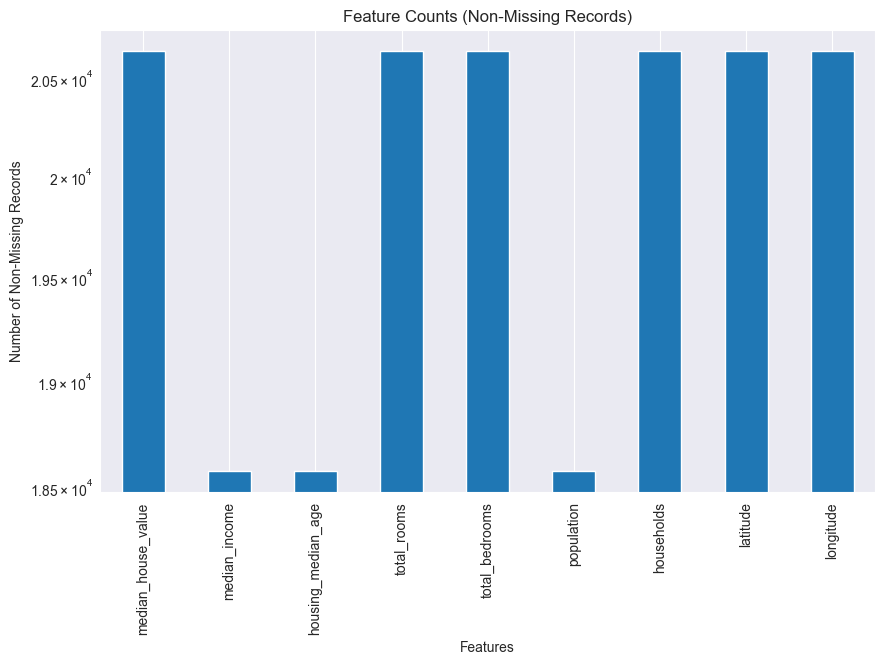

In [91]:
"""
plot a bar chart of features and their counts
"""
feature_counts = houses_corrupted.notna().sum() #getting all records that AREN'T nan.
print(feature_counts)
plt.figure(figsize=(10, 6))
feature_counts.plot(kind='bar')
plt.title('Feature Counts (Non-Missing Records)')
plt.xlabel('Features')
plt.ylabel('Number of Non-Missing Records')
plt.yscale('log') #log scale for better visibility
plt.show()

From the bar chart we can see that the features with missing values are:
- median_income
- housing_median_age
- population

All three of them have the same number of missing values, 206.

to Identify which of these features should be removed and which should be imputed, we will see which other features they correlate with, so we can accurately predict and impute their values.

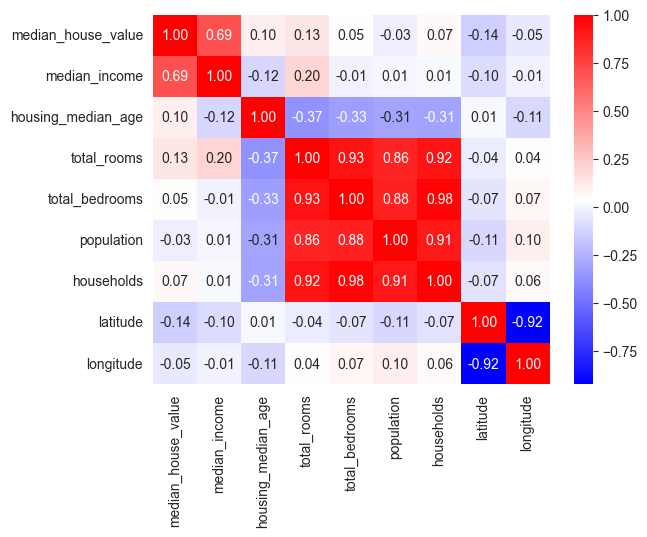

In [92]:
sns.heatmap(correlation_mat, annot=True, cmap="bwr", fmt=".2f")
plt.show()

We can see that:

- **median_income** corrleates with **median_house_value** with a coefficient of 0.69
- **population** correlates with **households** with a coefficient of 0.91  (also correlates strongly with total_bedrooms and total_rooms)
- **housing_median_age** doesn't correlate with anything very strongly.

Now because **housing_median_age** doesn't correlate with anything, it can be challenging to accurately impute its value, but we have a few options:
- removing it completely (all records with that feature missing)
- impute with the median (may lead to less precise data)
- map it with its long and lat and take the value from the closet set of coordinates. (as housing estates tend to get built at the same time)

Now, to make this simple (and fulfil one of the bullet points), I'll just remove every entry where this feature is nan. The reason I can do this is because the number of rows the feature is missing is negligible compared to the entire dataset. (<1%)

In [93]:
print("size of df before removing housing_median_age", len(houses_corrupted))
houses_corrupted_cleaned = houses_corrupted.dropna(subset = ["housing_median_age"]) #drop every entry with a NAN at that feature
print("size of df after removal", len(houses_corrupted_cleaned))

size of df before removing housing_median_age 20640
size of df after removal 18576


Now we can impute our data. Let's start with KNN

The way KNN Imputation works is by:
1.  Calculate the Euclidean Distance from all entries that don't have missing data. This can be done by mapping the features and rows to a 2D matrix $\bf{X}$ with values $x_ij$ where $i$ is the row (or entry, sample whatever you wish to call it) and $j$ is the feature. if $x_pq$ is our missing value we would calculate the Euclidean Distances between the row with the missing values, $\bf{X_p}$, and every other row $\bf{X_i}$:

$$
d(\mathbf{X_p}, \mathbf{X_i}) = \sqrt{\sum_{j=1}^{N} (x_{pj} - x_{ij})^2} , \;  X_{ij} \notin \{\text{NaN}\}
$$
where N is the amount of features

2. Find the $K$ number of rows with the smallest Euclidean Distance, where $K$ is of course, the number of neighbors we define.
3. You then take a (uniform) average or a weighted average of these neighbors $X_q$ feature. The weight depending on how close the neighbor is (usually the reciprocal of the distance, so the smaller the distance, the larger the weight)


In [94]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

features_cor_pop = ["households","total_bedrooms","total_rooms","population"] #relevant features for population to prevent uncorrelated noise

df_population_KNN = houses_corrupted_cleaned[features_cor_pop].copy()
print("amount of missing samples for non-imputed df", df_population_KNN['population'].isnull().sum()) #check how many missing values we have.
# initialize scaler - everything must be standardized
scaler_population = StandardScaler()

# fit and transform the data
scaled_population = scaler_population.fit_transform(df_population_KNN)

#using weighted KNN with 5 neighbous
knn_imputer_population = KNNImputer(n_neighbors=5, weights='distance')

#fit the standardized data
imputed_scaled_population = knn_imputer_population.fit_transform(scaled_population)
#inverse
imputed_population = scaler_population.inverse_transform(imputed_scaled_population)

# Create a DataFrame with imputed data
df_population_imputed_knn = pd.DataFrame(imputed_population, columns=features_cor_pop)

print("amount of missing samples of imputed df:", df_population_imputed_knn['population'].isnull().sum()) #check if all the missing values have been imputed
print("\n")

"""
Repeating for income, will join the DF's together later.
"""

features_cor_income = ["median_house_value", "median_income"]  #relevant features

df_income_KNN = houses_corrupted_cleaned[features_cor_income].copy()

#print("amount of missing samples for non-imputed df", df_income_KNN['median_income'].isnull().sum())  #amount of missing values

scaler_income = StandardScaler()  #Standardize

scaled_income = scaler_income.fit_transform(df_income_KNN)

knn_imputer_income = KNNImputer(n_neighbors=5,weights="distance")

imputed_scaled_income = knn_imputer_income.fit_transform(scaled_income)

imputed_income = scaler_income.inverse_transform(imputed_scaled_income)

df_income_imputed_knn = pd.DataFrame(imputed_income, columns=features_cor_income)

print("amount of missing samples of imputed df:", df_income_imputed_knn['median_income'].isnull().sum())


"""
create a copy of house_corrupted and add the imputed features
"""
houses_corrupted_knn = houses_corrupted_cleaned.copy() #new DF to store imputed + the rest of the features

#drop and reset indexes (as we removed some entries)
houses_corrupted_cleaned.reset_index(drop=True, inplace=True)
houses_corrupted_knn.reset_index(drop=True, inplace=True)
df_population_imputed_knn.reset_index(drop=True, inplace=True)

houses_corrupted_knn['population'] = df_population_imputed_knn['population']  #replace the population column

#same for income

df_income_imputed_knn.reset_index(drop=True, inplace=True)
houses_corrupted_knn["median_income"] = df_income_imputed_knn["median_income"] #replace the income column

print(houses_corrupted_knn.head(10))

amount of missing samples for non-imputed df 1859
amount of missing samples of imputed df: 0


amount of missing samples of imputed df: 0
   median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   
5            269700.0         4.0368                52.0        919.0   
6            299200.0         3.6591                52.0       2535.0   
7            241400.0         3.1200                52.0       3104.0   
8            226700.0         2.0804                42.0       2555.0   
9            261100.0         3.6912                52.0       3549.0   

   total_bedrooms   population  households  latitude  long

I used 5 neighbours as that's the default and I weighted it using distance.

Now we can use MICE to impute the data. Compare the two and the original data set.

**MICE** operates under the assumption the data is missing at random and uses an iterative approach

1) First impute the data with a placeholder, usually the mean or median of the feature.
2) for each feature that contains missing values $x_j$ we can say that it (from a probability perspective) it depends on all other features, then we can model the conditional distribution given our other (non-missing) features

$$
p(x_j | X_m:\theta)
$$

where $X_m$ are all other features and $\theta$ is our regression model

3) We choose a regression model, the default is Bayesian Ridge Regression, so we'll just use that. This is slightly more complicated than linear regression. It uses priors (essentially a guess into what the distrubution is going to be) and then updates this distribution based on the observable data (using bayes theorem).
4) Use this regressor on the missing data
5) Repeat step 4 a set number of times (iterations). constantly updating the missing data with the previous regressor outputs.

In [95]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

features_cor_pop = ["households","total_bedrooms","total_rooms","population"]
df_pop_to_impute = houses_corrupted_cleaned[features_cor_pop]
pop_imputer = IterativeImputer(estimator=None, #bayesian ridge by default
                                max_iter=10,  # iterations
                               random_state= 69) #reproducability

imputed_pop_vals = pop_imputer.fit_transform(df_pop_to_impute)

df_population_imputed_MICE = pd.DataFrame(imputed_pop_vals, columns = features_cor_pop)

"""
repeat for income
"""
features_cor_income = ["median_house_value", "median_income"]

df_cor_to_impute = houses_corrupted_cleaned[features_cor_income]

income_imputer = IterativeImputer(estimator= None,
                                  max_iter=10,
                                  random_state =69
                                  )

imputed_income_vals = income_imputer.fit_transform(df_cor_to_impute)

df_income_imputed_MICE = pd.DataFrame(imputed_income_vals, columns = features_cor_income)


"""
Merge back to a DF
"""

houses_corrupted_MICE = houses_corrupted_cleaned.copy() #create a MICE copy

houses_corrupted_MICE[features_cor_pop] = df_population_imputed_MICE[features_cor_pop] #add population

houses_corrupted_MICE[features_cor_income] = df_income_imputed_MICE[features_cor_income] #add median_income




Now we can compare the two against the original


In [96]:


# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)
missing_features = ["population", "median_income"] #our missing features
houses.drop(houses.index[median_age_rows], inplace = True) #drop the entries where median_house_age
houses.reset_index(drop = True, inplace=True)

print("for housing")
print(houses[missing_features].describe())
print("\n")
print("for knn")
print(houses_corrupted_knn[missing_features].describe())
print("\n")
print("for MICE")
print(houses_corrupted_MICE[missing_features].describe())


for housing
        population  median_income
count  18576.00000   18576.000000
mean    1476.15660       3.858223
std     1182.82664       1.900214
min        3.00000       0.499900
25%      750.00000       2.556350
50%     1255.00000       3.517900
75%     1811.00000       4.733300
max    35682.00000      15.000100


for knn
         population  median_income
count  18576.000000   18576.000000
mean    1476.225544       3.840542
std     1179.749229       1.879570
min        3.000000       0.499900
25%      760.868373       2.647700
50%     1243.000000       3.387934
75%     1806.000000       4.660800
max    35682.000000      15.000100


for MICE
         population  median_income
count  18576.000000   18576.000000
mean    1473.199726       3.854444
std     1179.089351       1.873594
min        3.000000       0.499900
25%      774.240648       2.650675
50%     1230.500000       3.368100
75%     1803.000000       4.660800
max    35682.000000      15.000100


Let's compare these outputs now. You will also see that I dropped the rows in which "median_house_age" was missing in the corrupted dataset. This will give a more fair and accurate (as we now have the same number of samples, maybe some of the other samples contained anomalies) comparison.

The simple way I see to do this is to use .comapre()

In [103]:
"""
Comparing the imputed datasets against the original
"""


comparison_knn = houses[missing_features].describe().compare(houses_corrupted_knn[missing_features].describe())
print("comparing knn against original")
print(comparison_knn)

print("\n")

comparison_MICE = houses[missing_features].describe().compare(houses_corrupted_MICE[missing_features].describe())
print(comparison_MICE)

comparing knn against original
      population              median_income          
            self        other          self     other
mean  1476.15660  1476.225544      3.858223  3.840542
std   1182.82664  1179.749229      1.900214  1.879570
min          NaN          NaN      0.499900  0.499900
25%    750.00000   760.868373      2.556350  2.647700
50%   1255.00000  1243.000000      3.517900  3.387934
75%   1811.00000  1806.000000      4.733300  4.660800


      population              median_income          
            self        other          self     other
mean  1476.15660  1473.199726      3.858223  3.854444
std   1182.82664  1179.089351      1.900214  1.873594
25%    750.00000   774.240648      2.556350  2.650675
50%   1255.00000  1230.500000      3.517900  3.368100
75%   1811.00000  1803.000000      4.733300  4.660800


We can see that the mean for both KNN and MICE compared to the original set is pretty much the same (up to 4 S.F) however, MICE seems to be a bit more precise with getting that extra S.F.


The STD we see a similar pattern except for the population we seem to go an extra significant figure.

for the quartiles MICE is off by 1 point on the 50% and 25% of the population metric. Being less precise than previous metrics. This seems to be the same for KNN except it's a bit less accurate (same precision). for median income. Even for median_income KNN seems to be a lot less accurate and precise than MICE.

### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation

#### Anamoly Detection

The methods I used for Anomaly Detection was Isolation Forest and IQR*1.5.

**Isolation Forest** - This obviously performs way better than the IQR method because we're working with multivariate data. This means that the anomalies that Isolation Forest catch are more likely to be true anamolies as it takes all features into consideration. However, its main downside is that it's complicated to understand and implement and requires a lot more computational power and time.
**IQR** - This method is a lot simpler to understand and implement, but its main downside is that its univariate only picks up single feature anamoliies.

**Challenges** For me personally, I don't see the point in implementing something if you don't fundamentally understand how it works. (that's why there's a lot of math in here). The hardest part about this was understanding how isolation forest works from the math. But once you understand it, it's smooth sailing.


#### Imputation

**KNN** - This method is fairly simple compared to MICE - just comparing distances and taking averages. It definitely requires less computational power as MICE is iterative and goes through the dataset multiple times over. However, as you saw in when comparing to the original dataset it's a lot less precise

**MICE** - This method is a lot harder to understand and a lot more tedious - you need to be careful in things you choose, such as max_iterations or your regressor (estimator) which can speed things up or slow things down depending on how you change it. However, when it comes to the actual implementation (using sci-kit anyway) they're both very similar as it's on a relatively high level of abstraction.

**challanges** again, it was trying to understand the math, more specifically, bayesian ridge regression. but besides that there weren't alot of challenges.